In [ ]:
import pandas as pd
import numpy as np

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

In [287]:
tickers = ['NXE', 'CCJ']
stock_data = yf.download(tickers, 
                         start='2015-01-01', end='2025-01-01', 
                         interval='1d')
stock_data.head(5)

[*********************100%***********************]  2 of 2 completed


Price           Close              High               Low              Open  \
Ticker            CCJ    NXE        CCJ    NXE        CCJ    NXE        CCJ   
Date                                                                          
2015-01-02  14.647925  0.300  14.817937  0.300  14.558445  0.300  14.621081   
2015-01-05  14.200524  0.318  14.495810  0.318  13.994720  0.318  14.424226   
2015-01-06  14.164728  0.320  14.433168  0.320  14.084196  0.320  14.200520   
2015-01-07  14.039457  0.320  14.460015  0.320  13.985770  0.320  14.298950   
2015-01-08  14.352638  0.320  14.531598  0.320  14.137885  0.320  14.173677   

Price               Volume        
Ticker        NXE      CCJ   NXE  
Date                              
2015-01-02  0.300  1139600     0  
2015-01-05  0.318  1905800  1000  
2015-01-06  0.320  1445300     0  
2015-01-07  0.320  1209200     0  
2015-01-08  0.320  1743900     0

In [ ]:
close_df = stock_data['Close']
ccj_px = close_df.iloc[:, 0]
ccj_px.name = 'Close'

nxe_px = close_df.iloc[:, 1]
nxe_px.name = 'Close'
nxe_px.head(5)

Date
2015-01-02    0.300
2015-01-05    0.318
2015-01-06    0.320
2015-01-07    0.320
2015-01-08    0.320
Name: Close, dtype: float64

# Augmented Dickey-Fuller (ADF) Test
A type of statistical test called a unit root test and it returns a p-value.

Null Hypothesis: Non-Stationary

Alternative Hypothesis: Stationary or Trend-Stationary

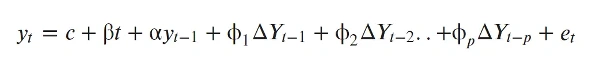

where $​ΔY_{t−1} = Y_{t-1} - Y_{t-2}$

- $y_t$​ is the value of the time series at time t
- $c$ is a constant (intercept)
- $β_t$ is a time trend component
- $αy_{t−1}$​ is the lagged value of the series
- $ϕ_1​ΔY_{t−1}​+ϕ_2​ΔY_{t−2}​+...+ϕ_p​ΔY_{t−p}$​ are the lagged differences
- $e_t$​ is the error term

$c$, $β_t$, $α$ and $ϕ$ are all computed using OLS regression (minimizing the sum of squared residuals).

The ADF test is fundamentally testing whether α=1. The p-value quantifies this by telling us the probability of getting an estimate as far from 1 as calculated, assuming the true value really is 1.

When α < 1, the process reverts to a deterministic trend and the variance remains finite. (Properties of a stationary process)

Source: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [430]:
def adf_stationarity_check(price:pd.Series, cutoff:float=0.05) -> tuple[float, bool]:
    # H0:= unit root exists (non-stationary)
    p = adfuller(price)[1]
    return (p, p < cutoff)

In [431]:
ticker1, ticker2 = tickers

print(f"Is {ticker1} Stationary: {adf_stationarity_check(nxe_px)[1]}")
print(f"Is {ticker2} Stationary: {adf_stationarity_check(ccj_px)[1]}")

Is NXE Stationary: False
Is CCJ Stationary: False


# Order of Integration

The minimum number of times a non-stationary time series needs to be differenced to become stationary I(0). However, to determine the order of integration, we need to do statistical tests like ADF.

In Finance, we simplify problems by assuming that stock prices follow a normal distribution. Consequently, we assume that stock prices are stationary with constant mean and finite variance.

In [432]:
def plot_dual_px(ticker1:str, ticker2:str, p1:pd.Series, p2:pd.Series):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(p1, 'g')
    ax1.set_ylabel(f'{ticker1} Price', color='g')

    ax2.plot(p2, 'b')
    ax2.set_ylabel(f"{ticker2} Price", color='b')

    plt.title(f'{ticker1} vs {ticker2} Price Comparison')
    fig.tight_layout()
    return fig, (ax1,ax2)

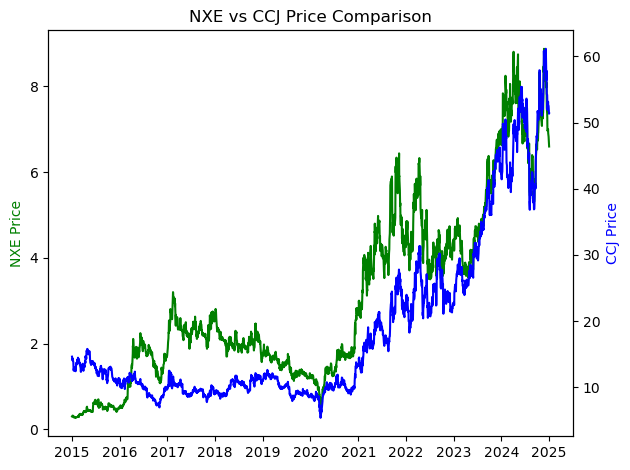

In [433]:
fig, axes = plot_dual_px(ticker1, ticker2, nxe_px, ccj_px)
plt.show()

Is NXE Stationary: True
Is CCJ Stationary: True


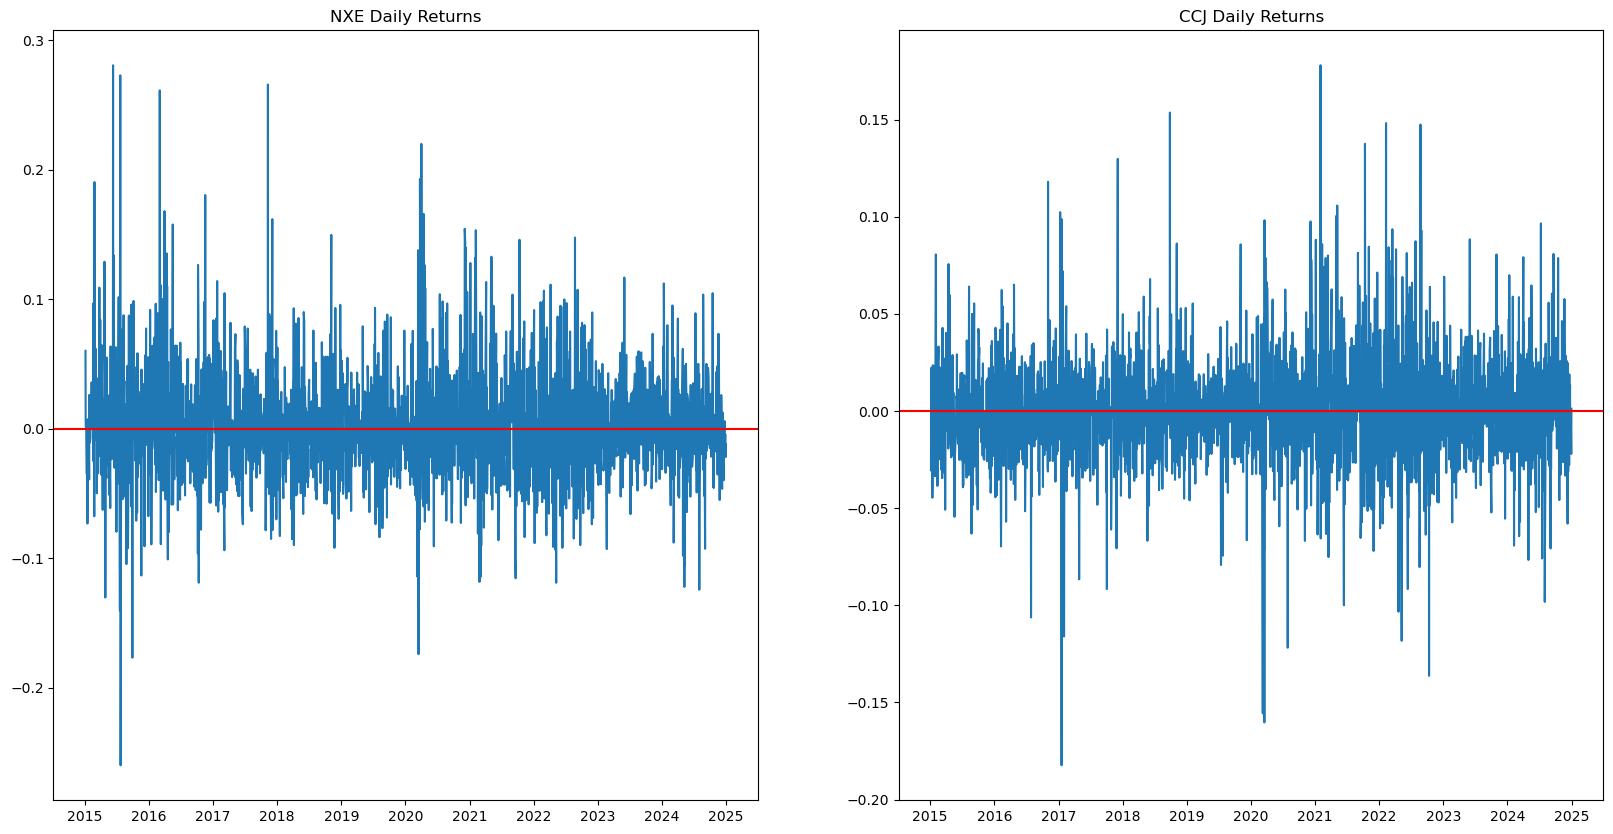

In [434]:
nxe_dreturn = nxe_px.pct_change(1)
ccj_dreturn = ccj_px.pct_change(1)

print(f"Is {ticker1} Stationary: {adf_stationarity_check(nxe_dreturn.values[1:])[1]}")
print(f"Is {ticker2} Stationary: {adf_stationarity_check(ccj_dreturn.values[1:])[1]}")

fig, axs = plt.subplots(ncols=2, figsize=(20,10))
axs[0].plot(nxe_dreturn)
axs[0].axhline(y=0, color='r', linestyle='-')
axs[0].set_title(f"{ticker1} Daily Returns")

axs[1].plot(ccj_dreturn)
axs[1].axhline(y=0, color='r', linestyle='-')
axs[1].set_title(f"{ticker2} Daily Returns")

plt.show()

# Cointegration

After finding a pair with stationary returns, we need to verify the pair's cointegration. 

If you have some set of I(1) time series that can form a stationary linear combination, that set is cointegrated (stationary together). 

For this case, we assume a 1:1. However, we should find a more statistical approach to find the optimal hedge ratio.

Is Stationary: False


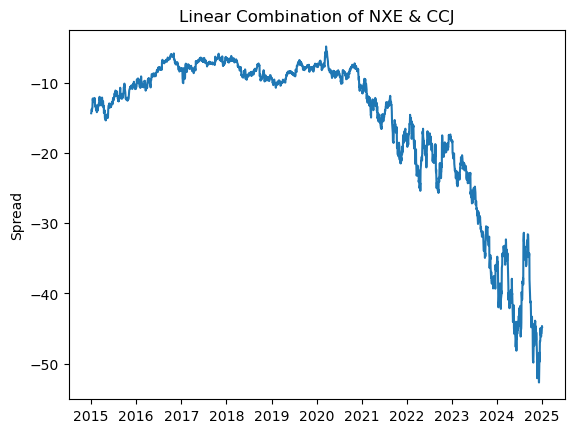

In [436]:
r_diff = nxe_px - ccj_px
print(f"Is Stationary: {adf_stationarity_check(r_diff.values)[1]}")

plt.plot(r_diff)
plt.ylabel('Spread')
plt.title(f"Linear Combination of {ticker1} & {ticker2}")
plt.show()

# Engle-Granger Two-Step Method
By representing the price of Stock A as a linear regression of the price of Stock B and finding the residuals. We can test whether the residuals are not stationary. Ideally, we want to reject the null hypothesis.

$X_2 = β_0 + β_1X_1 + ε$

$ε = X_2 - (β_0 + β_1X_1)$

However, include the constant will imply that the spread will have a persistent drift, which prevents it from being mean-reverting. Hence, we omit the constant to assume that the spread has no deterministic trend.

$ε = X_2 - β_1X_1$

In [414]:
def linear_reg(x2:pd.Series, x1:pd.Series) -> list[float]:
    """
    args: Dependent, Independent
    
    returns: [constant, gradient]
    """
    x1 = sm.add_constant(x1)
    results = sm.OLS(x2, x1).fit()
    x1 = x1.drop(columns=['const'])
    x1 = x1.iloc[:, 0]
    return results.params

Is Stationary: False


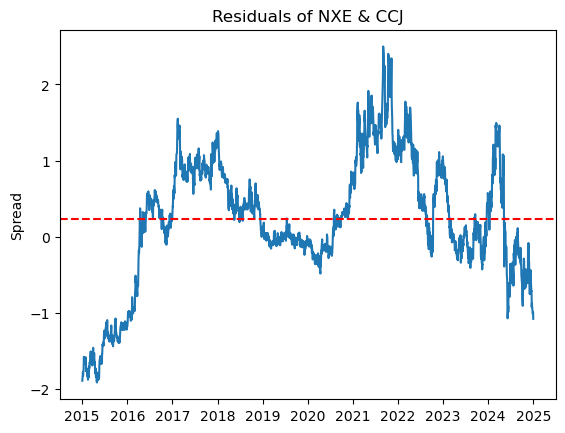

In [437]:
c,m = linear_reg(nxe_px, ccj_px)
residuals_daily = nxe_px - m*ccj_px
print(f"Is Stationary: {adf_stationarity_check(residuals_daily)[1]}")

plt.plot(residuals_daily)
plt.axhline(np.mean(residuals_daily), color='red', linestyle='--')
plt.ylabel('Spread')
plt.title(f"Residuals of {ticker1} & {ticker2}")
plt.show()

In [438]:
# Simpler Method
t, p, crit_value = coint(nxe_px, ccj_px) #Dependent, Independent
print(f"Is Stationary: {p<0.05}")

Is Stationary: False


## Explore Potential Stationary Relationships on Daily Price

In [ ]:
def explore_stationarity(s1:pd.Series, s2:pd.Series, cutoff:float=0.05) -> pd.DataFrame:
    """
    args: Dependent, Independent, Confidence Score
    
    returns: Dataframe of Results
    """
    #Normal Cointegration
    c,m = linear_reg(s1, s2)
    residuals = s1 - m*s2
    p, is_stationary = adf_stationarity_check(residuals, cutoff)
    coint_dict = {'simple': (p, is_stationary, m)}
    
    #Ratio
    ratio = s1/s2
    p, is_stationary = adf_stationarity_check(ratio, cutoff)
    coint_dict['ratio'] = (p, is_stationary, m) #m is same as normal coinegration

    #Log Transformation
    s1_ln, s2_ln = np.log(s1), np.log(s2)
    c,m = linear_reg(s1_ln, s2_ln)
    residuals = s1_ln - m*s2_ln
    p, is_stationary = adf_stationarity_check(residuals, cutoff)
    coint_dict['log'] = (p, is_stationary, m)

    coint_df = pd.DataFrame.from_dict(coint_dict, orient='index', columns=['p', 'is_stationary', 'hedge_ratio'])
    return coint_df

We notice that the hedge ratio for log-scaled price is drastically different from the normal prices. 

Instead of thinking about the hedge ratio in terms of position sizing, think about it in terms of price movement.

$$
\epsilon = X_2 - \beta X_1
$$

$$
\epsilon = lnX_2 - \beta lnX_1 
$$

In both spaces, the hedge ratio indicates that a 1% move in $X_2$ should result in a $\beta%$ move in $X_1$. Hence, I will long 1 unit of $X_1$ and short $\beta$ units of $X_2$. I am creating a position where the percentage movements in one stock are expected to offset the percentage movements in the other, based on their historical relationship.

In the normal price space, I am concerned about the absolute price difference. If $X_2$ is priced at $40 and $X_1$ is priced at $20, a 1% move in both stocks will yield different profit/loss. Hence, the lower hedge ratio of 0.149.

In the log price space, I am concerned about the relative price difference. A 1% move in the log prices of both stocks is expected to have the same profit/loss.

In [460]:
daily_rs = explore_stationarity(nxe_px, ccj_px)
daily_rs.index = ['daily_simple', 'daily_ratio', 'daily_log']
print(daily_rs)

                     p  is_stationary  hedge_ratio
daily_simple  0.092768          False     0.149346
daily_ratio   0.098693          False     0.149346
daily_log     0.006215           True     1.029957


Is Stationary: True


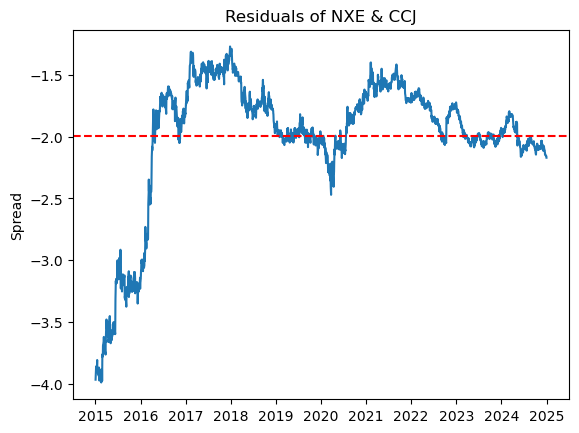

In [515]:
ln_nxe_px, ln_ccj_px = np.log(nxe_px), np.log(ccj_px)
c,m = linear_reg(ln_nxe_px, ln_ccj_px)
residuals_daily = ln_nxe_px - m*ln_ccj_px
print(f"Is Stationary: {adf_stationarity_check(residuals_daily)[1]}")

plt.plot(residuals_daily)
plt.axhline(np.mean(residuals_daily), color='red', linestyle='--')
plt.ylabel('Spread')
plt.title(f"Residuals of {ticker1} & {ticker2}")
plt.show()

## Explore Potential Stationary Relationships on Monthly Price

In [441]:
def month_end_px(px:pd.DataFrame) -> pd.DataFrame:
    df = px.reset_index()
    df = df.groupby(df['Date'].dt.strftime('%Y-%m'))
    df = df['Close'].last().reset_index()
    df = df.set_index('Date')
    return df

In [442]:
ccj_monthly = month_end_px(ccj_px)
nxe_monthly = month_end_px(nxe_px)
nxe_monthly.head(5)

,Close
Date,
2015-01,0.277
2015-02,0.340
2015-03,0.416
2015-04,0.452
2015-05,0.427


In [462]:
monthly_rs = explore_stationarity(nxe_monthly, ccj_monthly)
monthly_rs.index = ['monthly_simple', 'monthly_ratio', 'monthly_log']
print(monthly_rs)

                       p  is_stationary  hedge_ratio
monthly_simple  0.124243          False     0.148083
monthly_ratio   0.000198           True     0.148083
monthly_log     0.000322           True     1.019138


Is Stationary: True


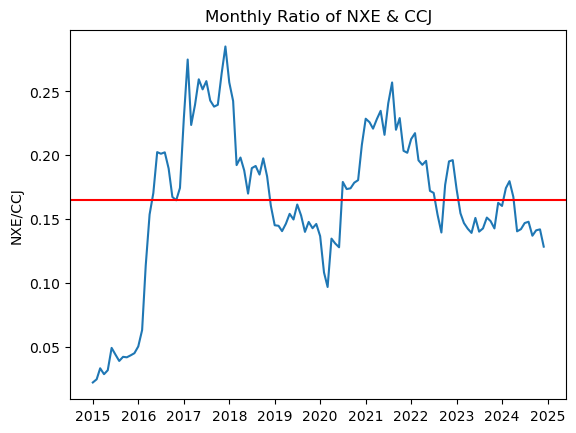

In [756]:
monthly_ratio_hedge = monthly_rs.loc['monthly_ratio', 'hedge_ratio']
monthly_ratio = nxe_monthly/ccj_monthly
monthly_ratio.index = pd.to_datetime(monthly_ratio.index)
monthly_ratio = monthly_ratio['Close'] #Convert to Series
print(f"Is Stationary: {adf_stationarity_check(monthly_ratio)[1]}")

plt.plot(monthly_ratio)
plt.axhline(np.mean(monthly_ratio), color='r', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylabel(f'{ticker1}/{ticker2}')
plt.title(f"Monthly Ratio of {ticker1} & {ticker2}")
plt.show()

Is Stationary: True


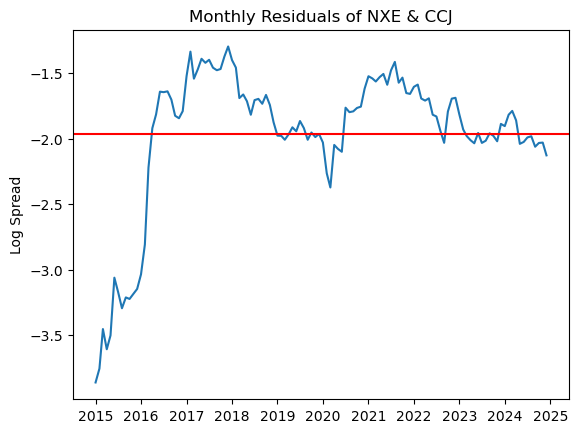

In [768]:
ln_nxe_m, ln_ccj_m = np.log(nxe_monthly), np.log(ccj_monthly)
c, monthly_m = linear_reg(ln_nxe_m, ln_ccj_m)
residuals_monthly = ln_nxe_m - monthly_m*ln_ccj_m
residuals_monthly.index = pd.to_datetime(residuals_monthly.index)
residuals_monthly = residuals_monthly['Close'] #Convert to Series
print(f"Is Stationary: {adf_stationarity_check(residuals_monthly)[1]}")

plt.plot(residuals_monthly)
plt.axhline(np.mean(residuals_monthly), color='r', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.ylabel('Log Spread')
plt.title(f"Monthly Residuals of {ticker1} & {ticker2}")
plt.show()

# Pair Selection Rule

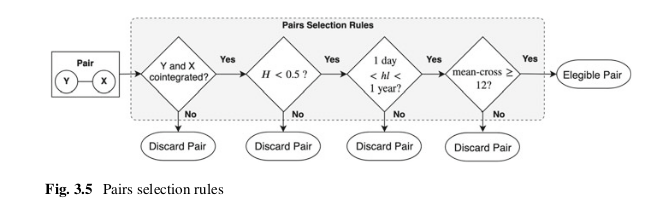

Source: https://hudsonthames.org/employing-machine-learning-for-trading-pairs-selection/

We could run a backtest on every stationary relationship, but that will be computationally expensive. Hence, we will use a rule-based approach to narrow down the list.

In [558]:
pair_df = pd.concat([daily_rs, monthly_rs])
pair_df = pair_df.loc[pair_df['is_stationary'] == True, ['p', 'hedge_ratio']]
pair_df

,p,hedge_ratio
daily_log,0.006215,1.029957
monthly_ratio,0.000198,0.148083
monthly_log,0.000322,1.019138


## Hurst Exponent

The Hurst exponent is used as a measure of long-term memory of time series. It measures the autocorrelations of the time series or in this case it measures how mean-reverting is the spread.

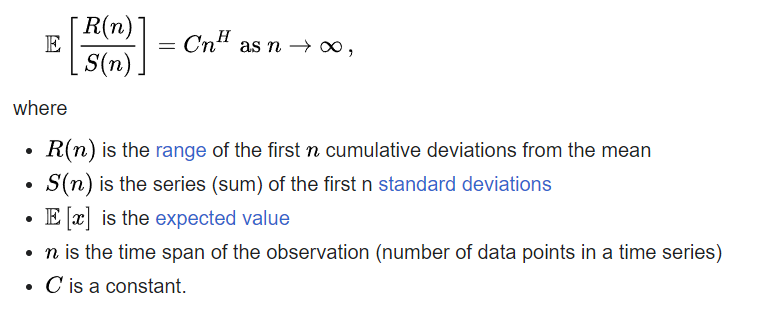

Source: https://en.wikipedia.org/wiki/Hurst_exponent

The Hurst exponent is not calculated but estimated. We calculate the $E[R/S]$ values of different chunks, and log both $E[R/S]$ and the time lag to transform their power law relationship into a linear form.

Then, we plot the log-log chart and calculate the best fit line, where the slope is the best-estimate of $H$. 

Note that R/S is the dependent variable, while the time lag is the independent variable.

Trending Tendencies
- $0.5 < H <= 1$: Long-Term Positive Autocorrelation, autocorrelation decay follows the power law and is slower than exponential.

Random-Walk (not strictly 0.5, but very close)
- $H = 0.5$: Short-Memory, autocorrelation decays exponentially quickly to 0.

Mean-Revering Tendencies
- $0 <= H < 0.5$: Long-Term alternation between high and low values, following the power law. 

In [769]:
def calculate_rs(time_series:np.array, lag:int) -> float|None:
    n_chunks = len(time_series)//lag
    if n_chunks == 0:
        return None
    
    rs_values = []
    for i in range(n_chunks):
        start, end = i*lag, (i+1)*lag
        chunk = time_series[start:end]
        chunk_mean = np.mean(chunk)
        mean_adj = chunk - chunk_mean
        cum_deviate = np.cumsum(mean_adj)
        r = np.max(cum_deviate) - np.min(cum_deviate)
        s = np.std(chunk)
        
        if s > 0:
            rs = r/s
            rs_values.append(rs)
            
    if len(rs_values) >0:
        return np.mean(rs_values)
    else:
        return None

def calculate_hurst(time_series:np.array, min_lag:int=10, max_lag:int=100, points:int=20) -> tuple[float, float, np.array, np.array]:
    series_len = len(time_series)
    log_spacing = np.logspace(np.log10(min_lag),
                              np.log10(min(max_lag, series_len//2)),
                              points,
                              dtype=int) #Log Base 10, because min_lag, max_lag is of base 10, ln will not work.
    lags = list(log_spacing[log_spacing>1]) #Lag >= 2 to capture meaningful trends instead of being dominated solely by noise
    rs_values = []
    for lag in lags:
        rs = calculate_rs(time_series, lag)
        if rs is not None:
            rs_values.append(rs)
        else:
            lags.remove(lag)
    
    lags = np.array(lags)
    rs_values = np.array(rs_values)
    ln_lags = np.log(lags)
    ln_rs_values = np.log(rs_values)
    
    coeffs = np.polyfit(ln_lags,ln_rs_values, 1)
    hurst_exponent, c = coeffs
    return hurst_exponent, c, ln_lags, ln_rs_values

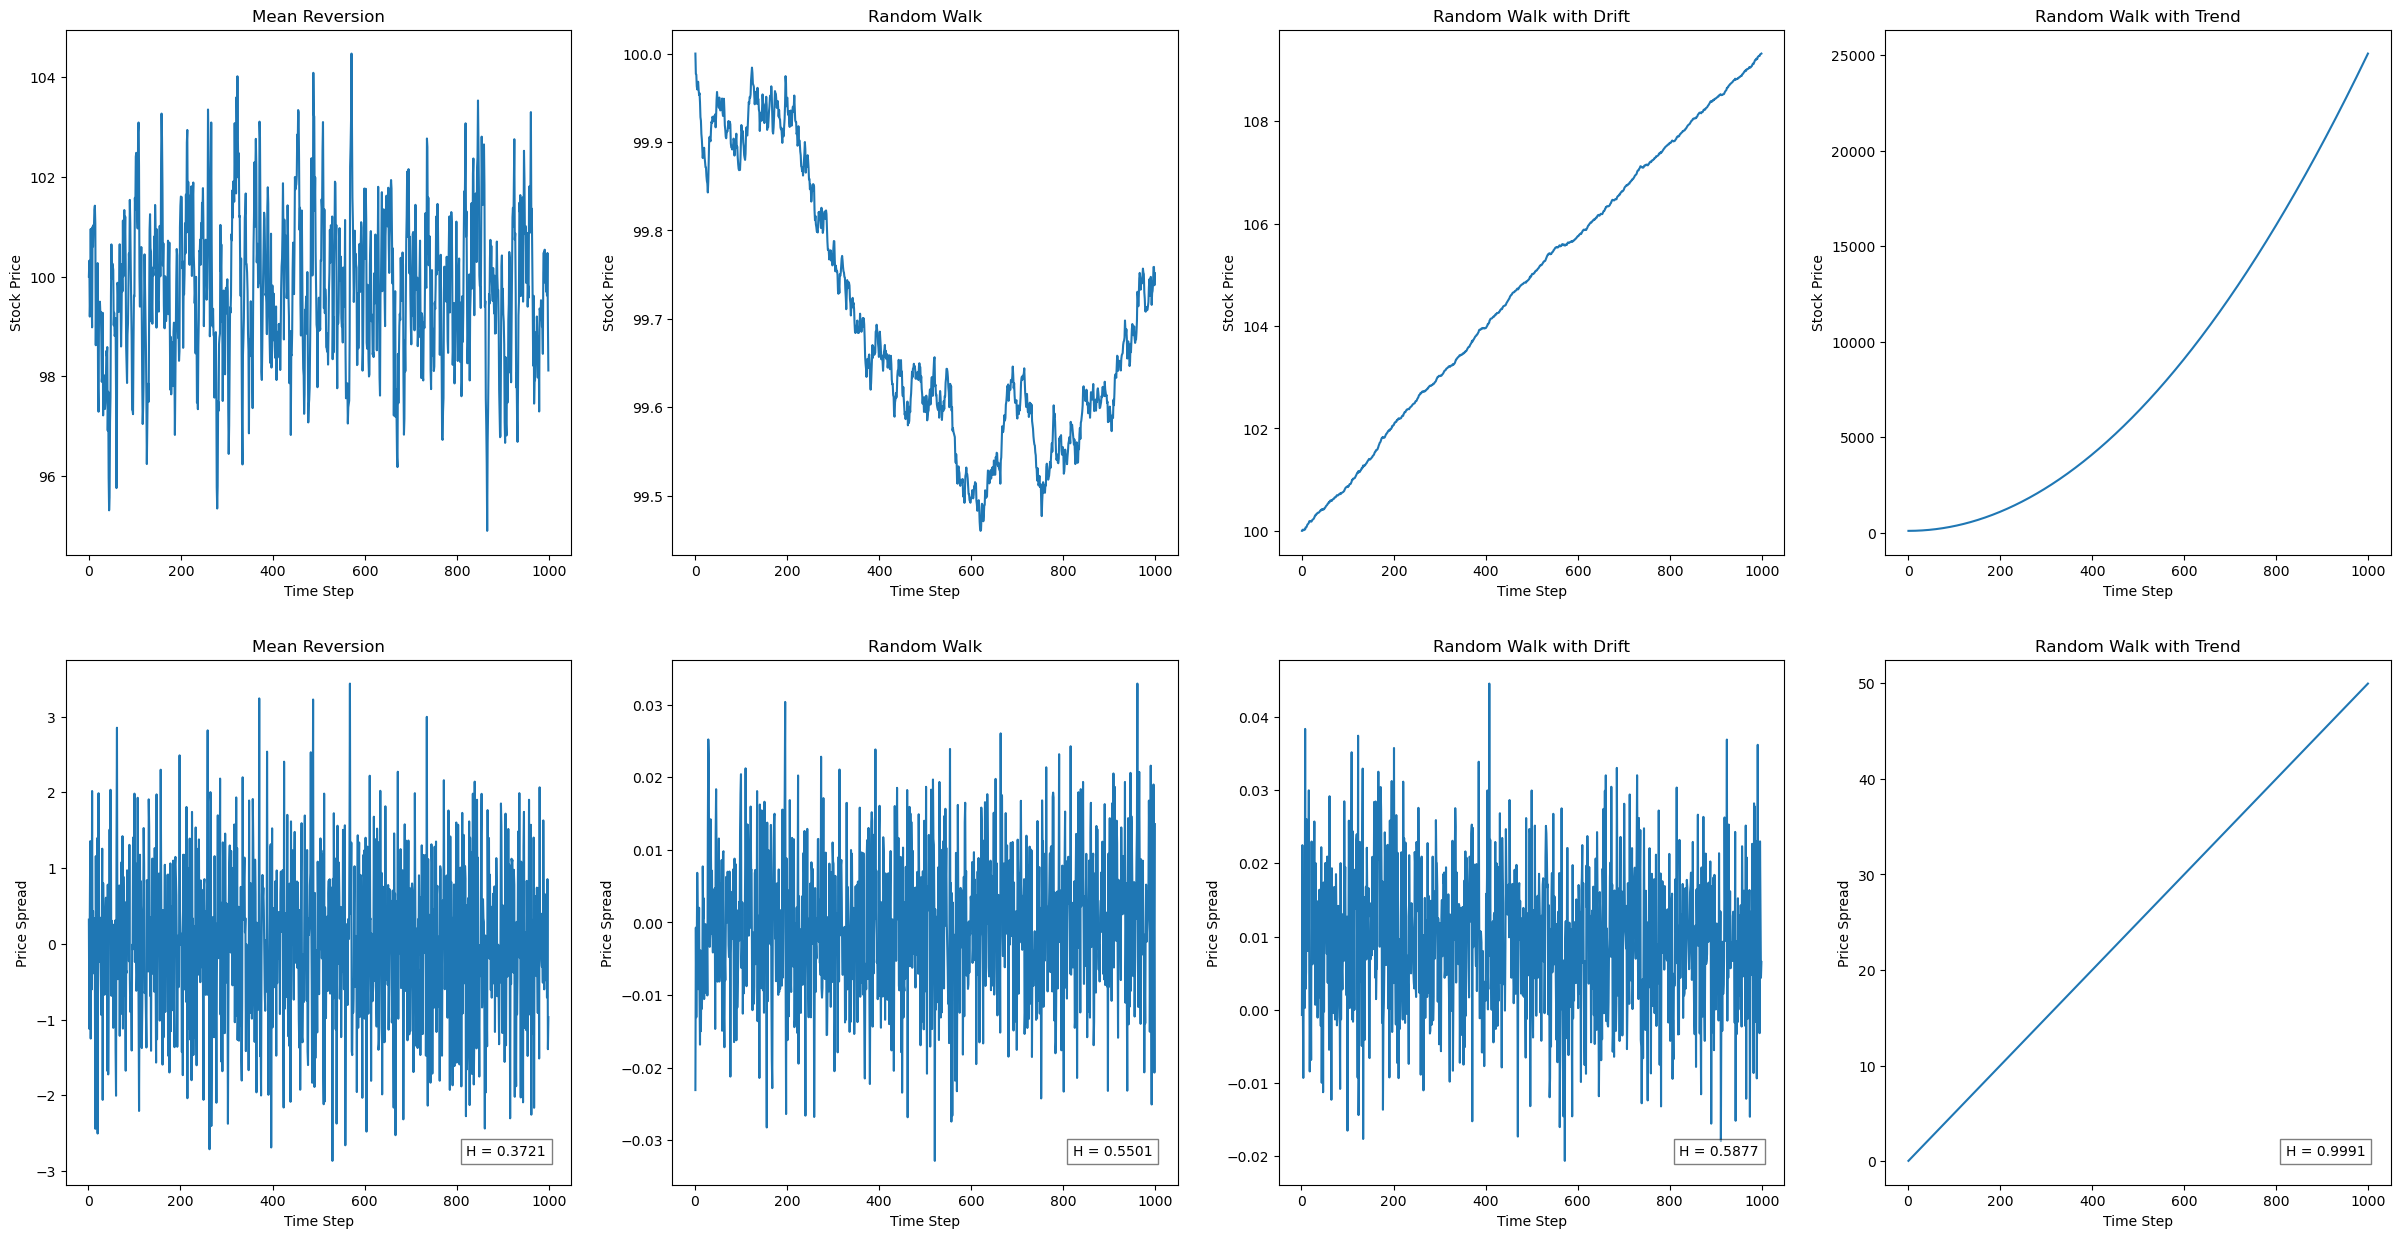

In [726]:
initial = 100
days = 1000

#Random-Walk Simulation
class StockPriceSimulations:
    def __init__(self, initial:float|int=100, days:int=252, volatility:float=0.01):
        self.initial = initial
        self.days = days
        self.volatility = volatility
    
    def init_price_series(self):
        price_series = np.zeros(self.days)
        price_series[0] = self.initial
        return price_series
    
    def vasicek_model(self, speed:float=0.2, mean:float|int=100):
        price_series = self.init_price_series()
        
        if price_series[0] > 0:
            price_series[0] = np.log(price_series[0])
        if mean > 0:
            mean = np.log(mean)
        Z = np.random.normal(0, 1, days)
        
        for t in range(1, days):
            price_change = speed*(mean-price_series[t-1]) + self.volatility*Z[t-1]
            price_series[t] = price_series[t-1] + price_change
        
        return np.exp(price_series)
    
    def random_walk(self, drift:float=0) -> np.array:
        noise = np.random.normal(0, self.volatility, self.days)
        price_series = self.init_price_series()
        
        for t in range(1, days):
            price_series[t] = price_series[t-1] + noise[t] + drift
        
        return price_series
    
    def trend_random_walk(self, trend_strength:float=0.05, direction_up:bool=True) -> np.array:
        direction = 1 if direction_up else -1
        trend = np.array([direction*trend_strength*t for t in range(self.days)])
        price_series = self.init_price_series()
        
        for t in range(1, days):
            price_series[t] = price_series[t-1] + trend[t]
        
        return price_series

sim = StockPriceSimulations(initial, days)
mean_revert_series = sim.vasicek_model()
mean_revert_spread = np.diff(mean_revert_series)

random_walk_series = sim.random_walk()
random_walk_spread = np.diff(random_walk_series)

random_walk_drift_series = sim.random_walk(drift=0.01)
random_walk_drift_spread= np.diff(random_walk_drift_series)

random_walk_trend_series = sim.trend_random_walk()
random_walk_trend_spread = np.diff(random_walk_trend_series)

#Plot
steps = range(0, days)
titles = ["Mean Reversion", "Random Walk", "Random Walk with Drift", "Random Walk with Trend"]
px_series = [mean_revert_series, random_walk_series, random_walk_drift_series, random_walk_trend_series]
px_spread = [mean_revert_spread, random_walk_spread, random_walk_drift_spread, random_walk_trend_spread]
hurst_values = [calculate_hurst(price_series)[0] for price_series in px_spread]

rows, cols = 2,4
fig,axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,15))

for col in range(cols):
    axes[0, col].plot(steps, px_series[col])
    axes[0, col].set_title(titles[col])
    axes[0, col].set_ylabel('Stock Price')
    axes[0, col].set_xlabel('Time Step')

for col in range(cols):
    axes[1, col].plot(steps[1:], px_spread[col])
    axes[1, col].set_title(titles[col])
    axes[1, col].set_ylabel('Price Spread')
    axes[1, col].set_xlabel('Time Step')
    axes[1, col].text(0.95, 0.05, f'H = {hurst_values[col]:.4f}', 
                transform=axes[1, col].transAxes,
                ha='right', va='bottom',
                bbox=dict(facecolor='white', alpha=0.5))

plt.show()


In [770]:
spreads = [residuals_daily, monthly_ratio, residuals_monthly]

In [771]:
hurst_values = [calculate_hurst(spread_series.values)[0] for spread_series in spreads]
pair_df['hurst_exponent'] = hurst_values
pair_df

,p,hedge_ratio,hurst_exponent
daily_log,0.006215,1.029957,0.996127
monthly_ratio,0.000198,0.148083,1.041105
monthly_log,0.000322,1.019138,1.048909


Sometimes $H$ can be more than 1, which should not be the case as $H$ is bounded between 0 and 1. However, this is usually due to a small sample bias of the monthly data causing our best-fit line to overestimate the slope. Nonetheless, it does not matter as $H>=0.5$, which means that the pairs have trending tendencies and hence should be discarded.

In our case, none of the pairs are eligible for trading. But let us carry on assuming they are eligible.

## Half-Life

The mean-reverting spread series follows the Ornstein-Uhlenbeck process:
$$
dS_t = \kappa(\mu - S_{t-1}) + \epsilon_t
$$
where $\kappa$ determines the speed the spread reverts to the mean.

We assume that the spread is memoryless, where future decay solely depends on the current value:
$$
N_t = N_0e^{-\kappa t}
$$

Then the half-life can be calculated as:
$$
N_0/2 = N_0e^{-\kappa t}
$$
$$
ln(1/2) = ln(e^{-\kappa t})
$$
$$
-\kappa t = -ln(2)
$$
$$
t = ln(2)/\kappa
$$


In [775]:
def calculate_half_life(kappa:float, time:int=1) -> float:
    """
    time refers to:
    Daily - 1 day
    Weekly - 7 days
    Monthly - 30 days
    Yearly - 365 days
    """
    t = np.log(2)/kappa
    return t*time

def estimate_kappa(spread_series:np.array) -> float:
    dS = np.diff(spread_series)
    mean = np.mean(spread_series)
    x = mean - spread_series[:-1]
    c, kappa = linear_reg(pd.Series(dS), pd.Series(x))
    return kappa

kappa = estimate_kappa(residuals_daily.values)
half_life = calculate_half_life(kappa)
print(half_life)

151.6246636602736


In [776]:
half_life_values = []
for spread_series in spreads:
    kappa = estimate_kappa(spread_series.values)
    half_life = calculate_half_life(kappa)
    half_life_values.append(half_life)

Half-life is the time taken from the spread to mean-revert half of its distance. Since we are using daily and monthly spreads, we are focusing on the medium-term price movements.
$$
1 < t_{1/2} < 365
$$
where the unit is days.

In [786]:
pair_df['half_life'] = half_life_values
pair_df.iloc[1:, -1] =  pair_df.iloc[1:, -1]*30 #Convert months to days
pair_df

,p,hedge_ratio,hurst_exponent,half_life
daily_log,0.006215,1.029957,0.996127,151.624664
monthly_ratio,0.000198,0.148083,1.041105,302.031480
monthly_log,0.000322,1.019138,1.048909,266.373446


## Spread Crosses Mean at least 12 Times

Lastly, to ensure sufficient liquidity to exit a position, we check to ensure that the spread crosses the mean at least 12 times.

In [846]:
def mean_cross(price_series:np.array, mean:int|float = None, tolerance:int|float = 0.001) -> list[int]:
    """
    Returns a list indicating whenever the price series crosses the mean.
    
    args:
        tolerance: Reduces noise by adding a buffer to ignore volatile movements around the mean.
    returns:
        -1: Cross below the mean
        1: Cross above the mean
        0: No crosses
    """
    if mean is None:
        mean = np.mean(price_series)
    
    cross = 0
    signal = []
    for px in price_series:
        if px > mean+tolerance and cross != 1:
            cross = 1
            signal.append(cross)
        elif px < mean-tolerance and cross != -1:
            cross = -1
            signal.append(cross)
        else:
            signal.append(0)
    
    #Set initial value to 0 as price did not cross the mean
    signal[0] = 0
    return signal

cross_overs = [mean_cross(spread_series) for spread_series in spreads]
cross_overs_array = [np.array(crosses) for crosses in cross_overs]
total_crosses = [np.sum(abs(crosses)) for crosses in cross_overs_array]
pair_df['total_crosses'] = total_crosses
pair_df 

,p,hedge_ratio,hurst_exponent,half_life,total_crosses
daily_log,0.006215,1.029957,0.996127,151.624664,86
monthly_ratio,0.000198,0.148083,1.041105,302.031480,8
monthly_log,0.000322,1.019138,1.048909,266.373446,16


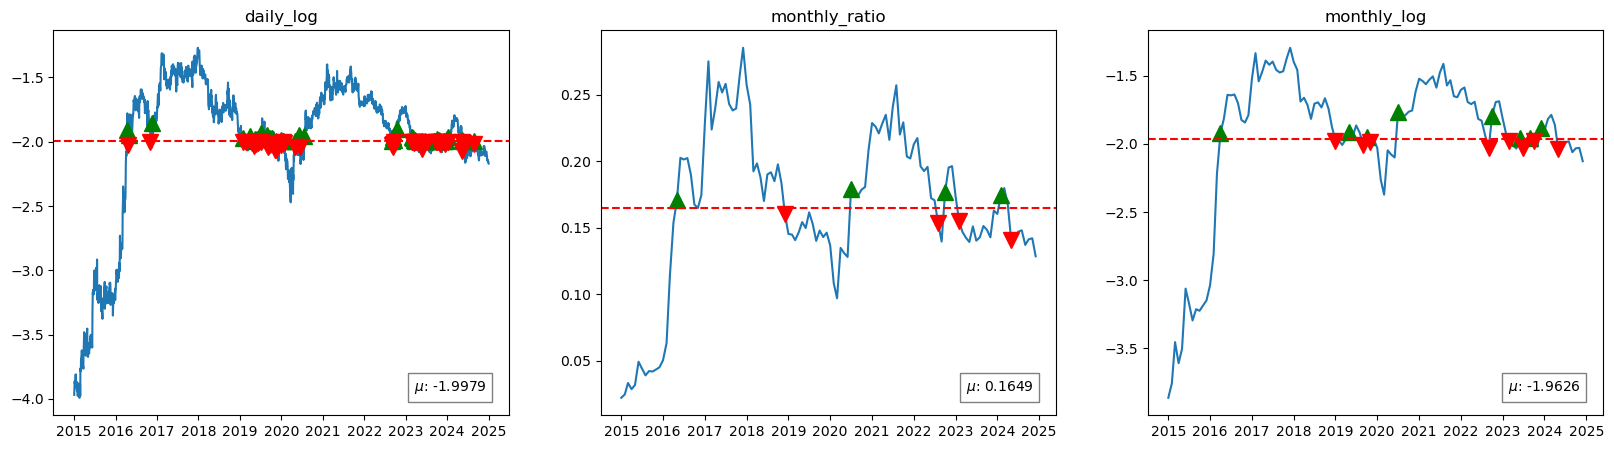

In [847]:
spread_means = [np.mean(spread_series) for spread_series in spreads]
titles = list(pair_df.index)

cols = 3
fig, axes = plt.subplots(ncols=cols, figsize=(20,5))
for col in range(cols):
    axes[col].plot(spreads[col])
    
    pos_mask = spreads[col].loc[cross_overs_array[col] == 1]
    axes[col].plot(pos_mask, '^', color='g', markersize=12)
    neg_mask = spreads[col].loc[cross_overs_array[col] == -1]
    axes[col].plot(neg_mask, 'v', color='r', markersize=12)
    
    axes[col].axhline(spread_means[col], color='r', linestyle='--')
    axes[col].set_title(titles[col])
    axes[col].text(0.95, 0.05, f"$\mu$: {spread_means[col]:.4f}",
                   transform=axes[col].transAxes,
                   ha='right', va='bottom',
                   bbox=dict(facecolor='white', alpha=0.5))
    
plt.show()